In [2]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [6]:
L = 15.0 
T = 1.0
t0 = 0.
m = 3
A = 0
B = 1.01
alpha = 1

In [7]:
def solution(x, t, m, A, B):
    return ((m*(x-A)**2)/(2*alpha*(m+2)*(B-t)))**(1./m)

In [8]:
def ic_func(x):
    x_space = x[:, 0:1]                
    return solution(x_space, t0, m, A,B) # analytic Barenblatt at t0

In [38]:
import deepxde as dde
import numpy as np


def pde_porous_medium(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    um1 = torch.pow(torch.clamp(u, min = 0), m-1)
    um = torch.pow(torch.clamp(u, min = 0), m)
    
    ddu = dde.grad.hessian(u,x,i = 0, j = 0)
    du = dde.grad.jacobian(u,x,i = 0, j = 0)
    return u_t - alpha*(um*ddu  + m*um1*du**2)  + (torch.abs(u) - u)**2

geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(t0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -L) #and not np.isclose(x[1], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) #and not np.isclose(x[1], 0)

# условия нулевые на достаточно далеком иксе
bc_left = dde.DirichletBC(
    geomtime,
    lambda x: solution(x[:,0:1],x[:,1:2],m,A,B),           
    boundary_left,
    component=0,
)

bc_right = dde.DirichletBC(
    geomtime,
    lambda x: solution(x[:,0:1],x[:,1:2],m,A,B),            
    boundary_right,
    component=0,
)

def on_initial(x, on_initial):
    return on_initial and np.isclose(x[1], t0)

ic = dde.IC(geomtime, ic_func, on_initial, component=0)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde_porous_medium,
    [bc_left, bc_right, ic],
    num_domain=10000,
    num_boundary=1000,
    num_initial=1000,
)

net = dde.nn.FNN(
    [2] + [50] * 6 + [1],  
    "tanh",
    "Glorot normal",
)

In [39]:
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

model = dde.Model(data, net)
model.compile("adam", lr=1e-3,loss_weights = [1,1,1,1])
model.train(iterations=5000,callbacks=[resampler])
model.compile('L-BFGS')

losshistory, train_state = model.train()

Compiling model...
'compile' took 0.001170 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.93e+00, 4.74e+01, 3.14e+01, 7.50e+00]    [1.93e+00, 4.74e+01, 3.14e+01, 7.50e+00]    []  
1000      [1.38e+00, 5.87e+00, 2.92e+00, 2.25e+00]    [1.39e+00, 5.87e+00, 2.92e+00, 2.25e+00]    []  
2000      [6.76e-01, 1.94e+00, 1.75e+00, 5.86e-02]    [6.74e-01, 1.94e+00, 1.75e+00, 5.86e-02]    []  
3000      [5.00e-01, 1.20e+00, 1.28e+00, 3.77e-02]    [5.00e-01, 1.20e+00, 1.28e+00, 3.77e-02]    []  
4000      [2.51e-01, 7.99e-01, 8.29e-01, 4.73e-02]    [2.53e-01, 7.99e-01, 8.29e-01, 4.73e-02]    []  
5000      [2.56e-01, 5.17e-01, 5.00e-01, 3.11e-02]    [2.55e-01, 5.17e-01, 5.00e-01, 3.11e-02]    []  

Best model at step 5000:
  train loss: 1.30e+00
  test loss: 1.30e+00
  test metric: []

'train' took 814.407436 s

Compiling model...
'compile' took 0.000635 s

Training model...

Step      Train loss     

Saving loss history to /home/ivan/MEPHI/nauchka/patlakov/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/patlakov/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/patlakov/test.dat ...


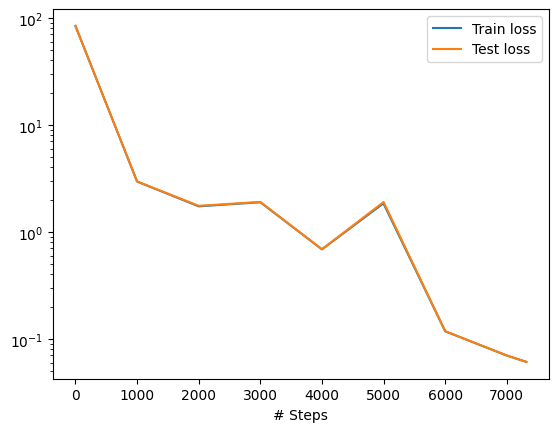

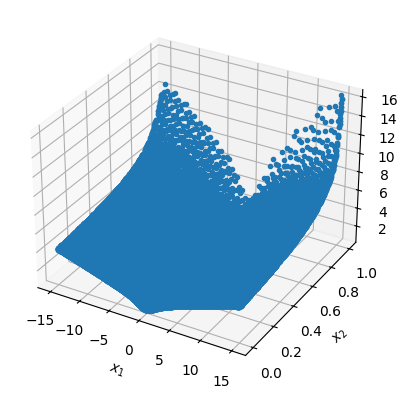

In [ ]:
dde.saveplot(losshistory, train_state)

In [11]:
    

n_x   = 1000
n_t   = 1000


x_vals   = np.linspace(-L, L, n_x)    
t_vals   = np.linspace(t0, T, n_t)      
X, T_grid = np.meshgrid(x_vals, t_vals)
XT       = np.vstack((X.ravel(), T_grid.ravel())).T

U_bar    = solution(X, T_grid, m, A,B)

U_pinn   = model.predict(XT).reshape(n_t, n_x)

U_diff   = np.abs(U_pinn - U_bar)
print(U_diff)
print(np.mean(np.mean(U_diff**2,axis=1)))
fig = plt.figure(figsize=(18, 15))
ax = fig.add_subplot(2,2,1, projection = '3d')
ax.plot_surface(X,T_grid,U_pinn)
ax.set_title('PINN solution',fontsize=30)

ax = fig.add_subplot(2,2,2, projection = '3d')
ax.plot_surface(X,T_grid,U_diff)
ax.set_title('PINN absolute error',fontsize = 30)


ax = fig.add_subplot(2,2,3)
ax.contourf(X,T_grid,U_pinn,levels = 30)
ax.set_title('PINN solution',fontsize=30)

ax = fig.add_subplot(2,2,4)
ax.contourf(X,T_grid,U_diff, levels = 30)
ax.set_title('PINN absolute error',fontsize = 30)


NameError: name 'model' is not defined

In [ ]:

import pandas as pd

data = {'X':XT[:,0], 'T':XT[:,1], 'U':model.predict(XT).T[0]}

df = pd.DataFrame(data)
#df.to_csv('50x4_10000x500x500_m=05_PINN.csv')


Text(0.5, 1.0, 'Exact solution')

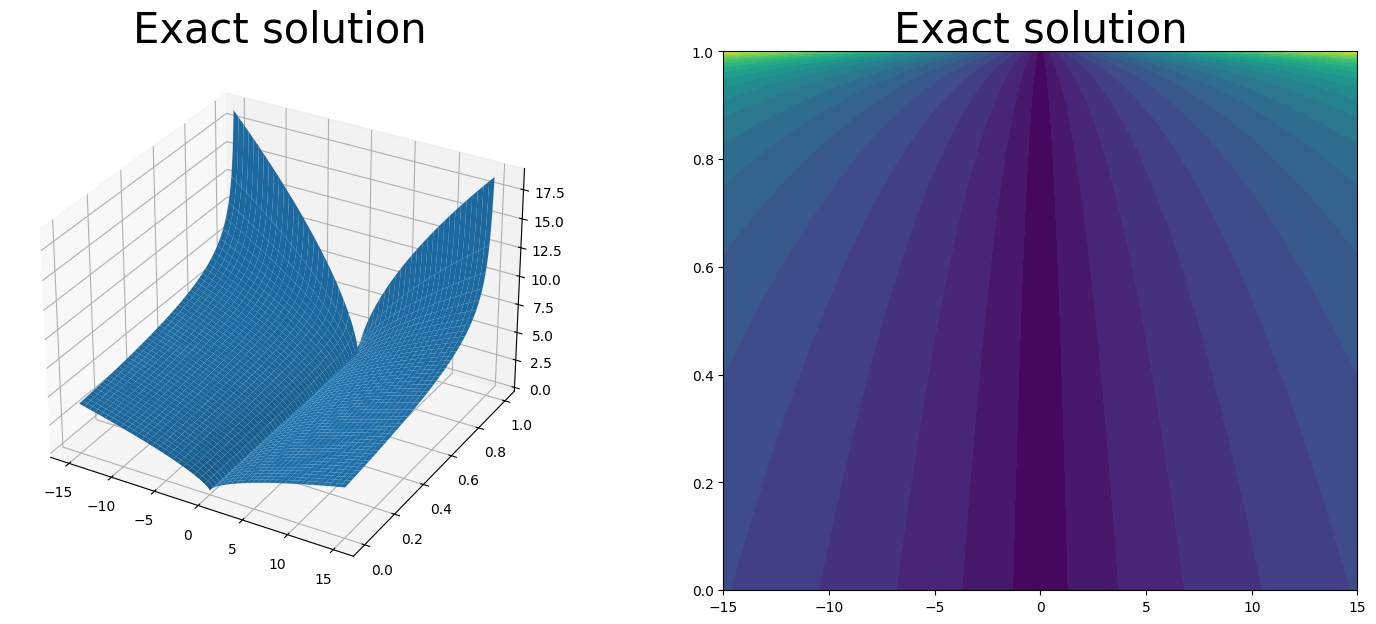

In [16]:
n_x   = 1000
n_t   = 1000


x_vals   = np.linspace(-L, L, n_x)    
t_vals   = np.linspace(t0, T, n_t)      
X, T_grid = np.meshgrid(x_vals, t_vals)
XT       = np.vstack((X.ravel(), T_grid.ravel())).T

fig = plt.figure(figsize=(18, 7))
ax = fig.add_subplot(1,2,1, projection = '3d')
ax.plot_surface(X,T_grid,U_bar)
ax.set_title('Exact solution',fontsize=30)


ax = fig.add_subplot(1,2,2)
ax.contourf(X,T_grid,U_bar,levels = 30)
ax.set_title('Exact solution',fontsize=30)
